# Regularization
I'm following the guide here: <https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html>.

## Load Data

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from nilearn import plotting, image, datasets

In [2]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [3]:
# Search for all functional connectivity files and read them
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivity:", len(fcs))
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of functional connectivity: 825
Number of features (connections): 34716


In [4]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path, index_col='assessment WISC,EID')
# display(wisc_labels)

In [5]:
subject_ids = wisc_labels.index
wisc_scaled_subtests = [
    'WISC_BD_Scaled', 
    'WISC_Similarities_Scaled', 
    'WISC_MR_Scaled',
    'WISC_DS_Scaled',
    'WISC_Coding_Scaled',
    'WISC_Vocab_Scaled',
    'WISC_FW_Scaled',
    'WISC_VP_Scaled',
    'WISC_PS_Scaled',
    'WISC_SS_Scaled',
]
wisc_primary_indices = [
    'WISC_VSI',
    'WISC_FRI',
    'WISC_WMI',
    'WISC_PSI',
    'WISC_VCI',
    'WISC_FSIQ',
]
wisc_measures = wisc_primary_indices
age_col = 'assessment Basic_Demos,Age'

fc_matrices = []
ages = []
measures = {measure: [] for measure in wisc_measures}

for subject_id in subject_ids:
    if subject_id not in fcs:
        continue
    
    fc_matrices.append(fcs[subject_id])
    ages.append(wisc_labels.at[subject_id, age_col])
    
    for measure in wisc_measures:
        measures[measure].append(
            wisc_labels.at[subject_id, f'assessment WISC,{measure}'])

ages = np.array(ages)
print("Num subjects with measures:", len(ages))
print("Num measures:", len(wisc_measures))

Num subjects with measures: 577
Num measures: 6


In [6]:
X = np.array(fc_matrices)

selected_measure = "WISC_FSIQ"
y = np.array(measures[selected_measure])

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (577, 34716) y shape: (577,)


## Train Ridge Model

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split

In [8]:
reg_strength = 1000
kf = KFold(n_splits=10)
train_scores = []
test_scores = []
coefs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ridge = Ridge(alpha=reg_strength)
    ridge.fit(X_train, y_train)
    
    train_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    coefs.append(ridge.coef_)

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)
avg_coef = np.mean(coefs, axis=0)

print("Avg train score:", avg_train_score)
print("Avg test score:", avg_test_score)

Avg train score: 0.7017901202712592
Avg test score: 0.1213365424246771


In [9]:
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

def create_power_fc_matrix(connections):
    fc = np.zeros((264, 264))
    fc[np.triu_indices(264, k=1)] = connections
    fc = fc + fc.T
    return fc

(34716,) -0.12795971 0.11846963


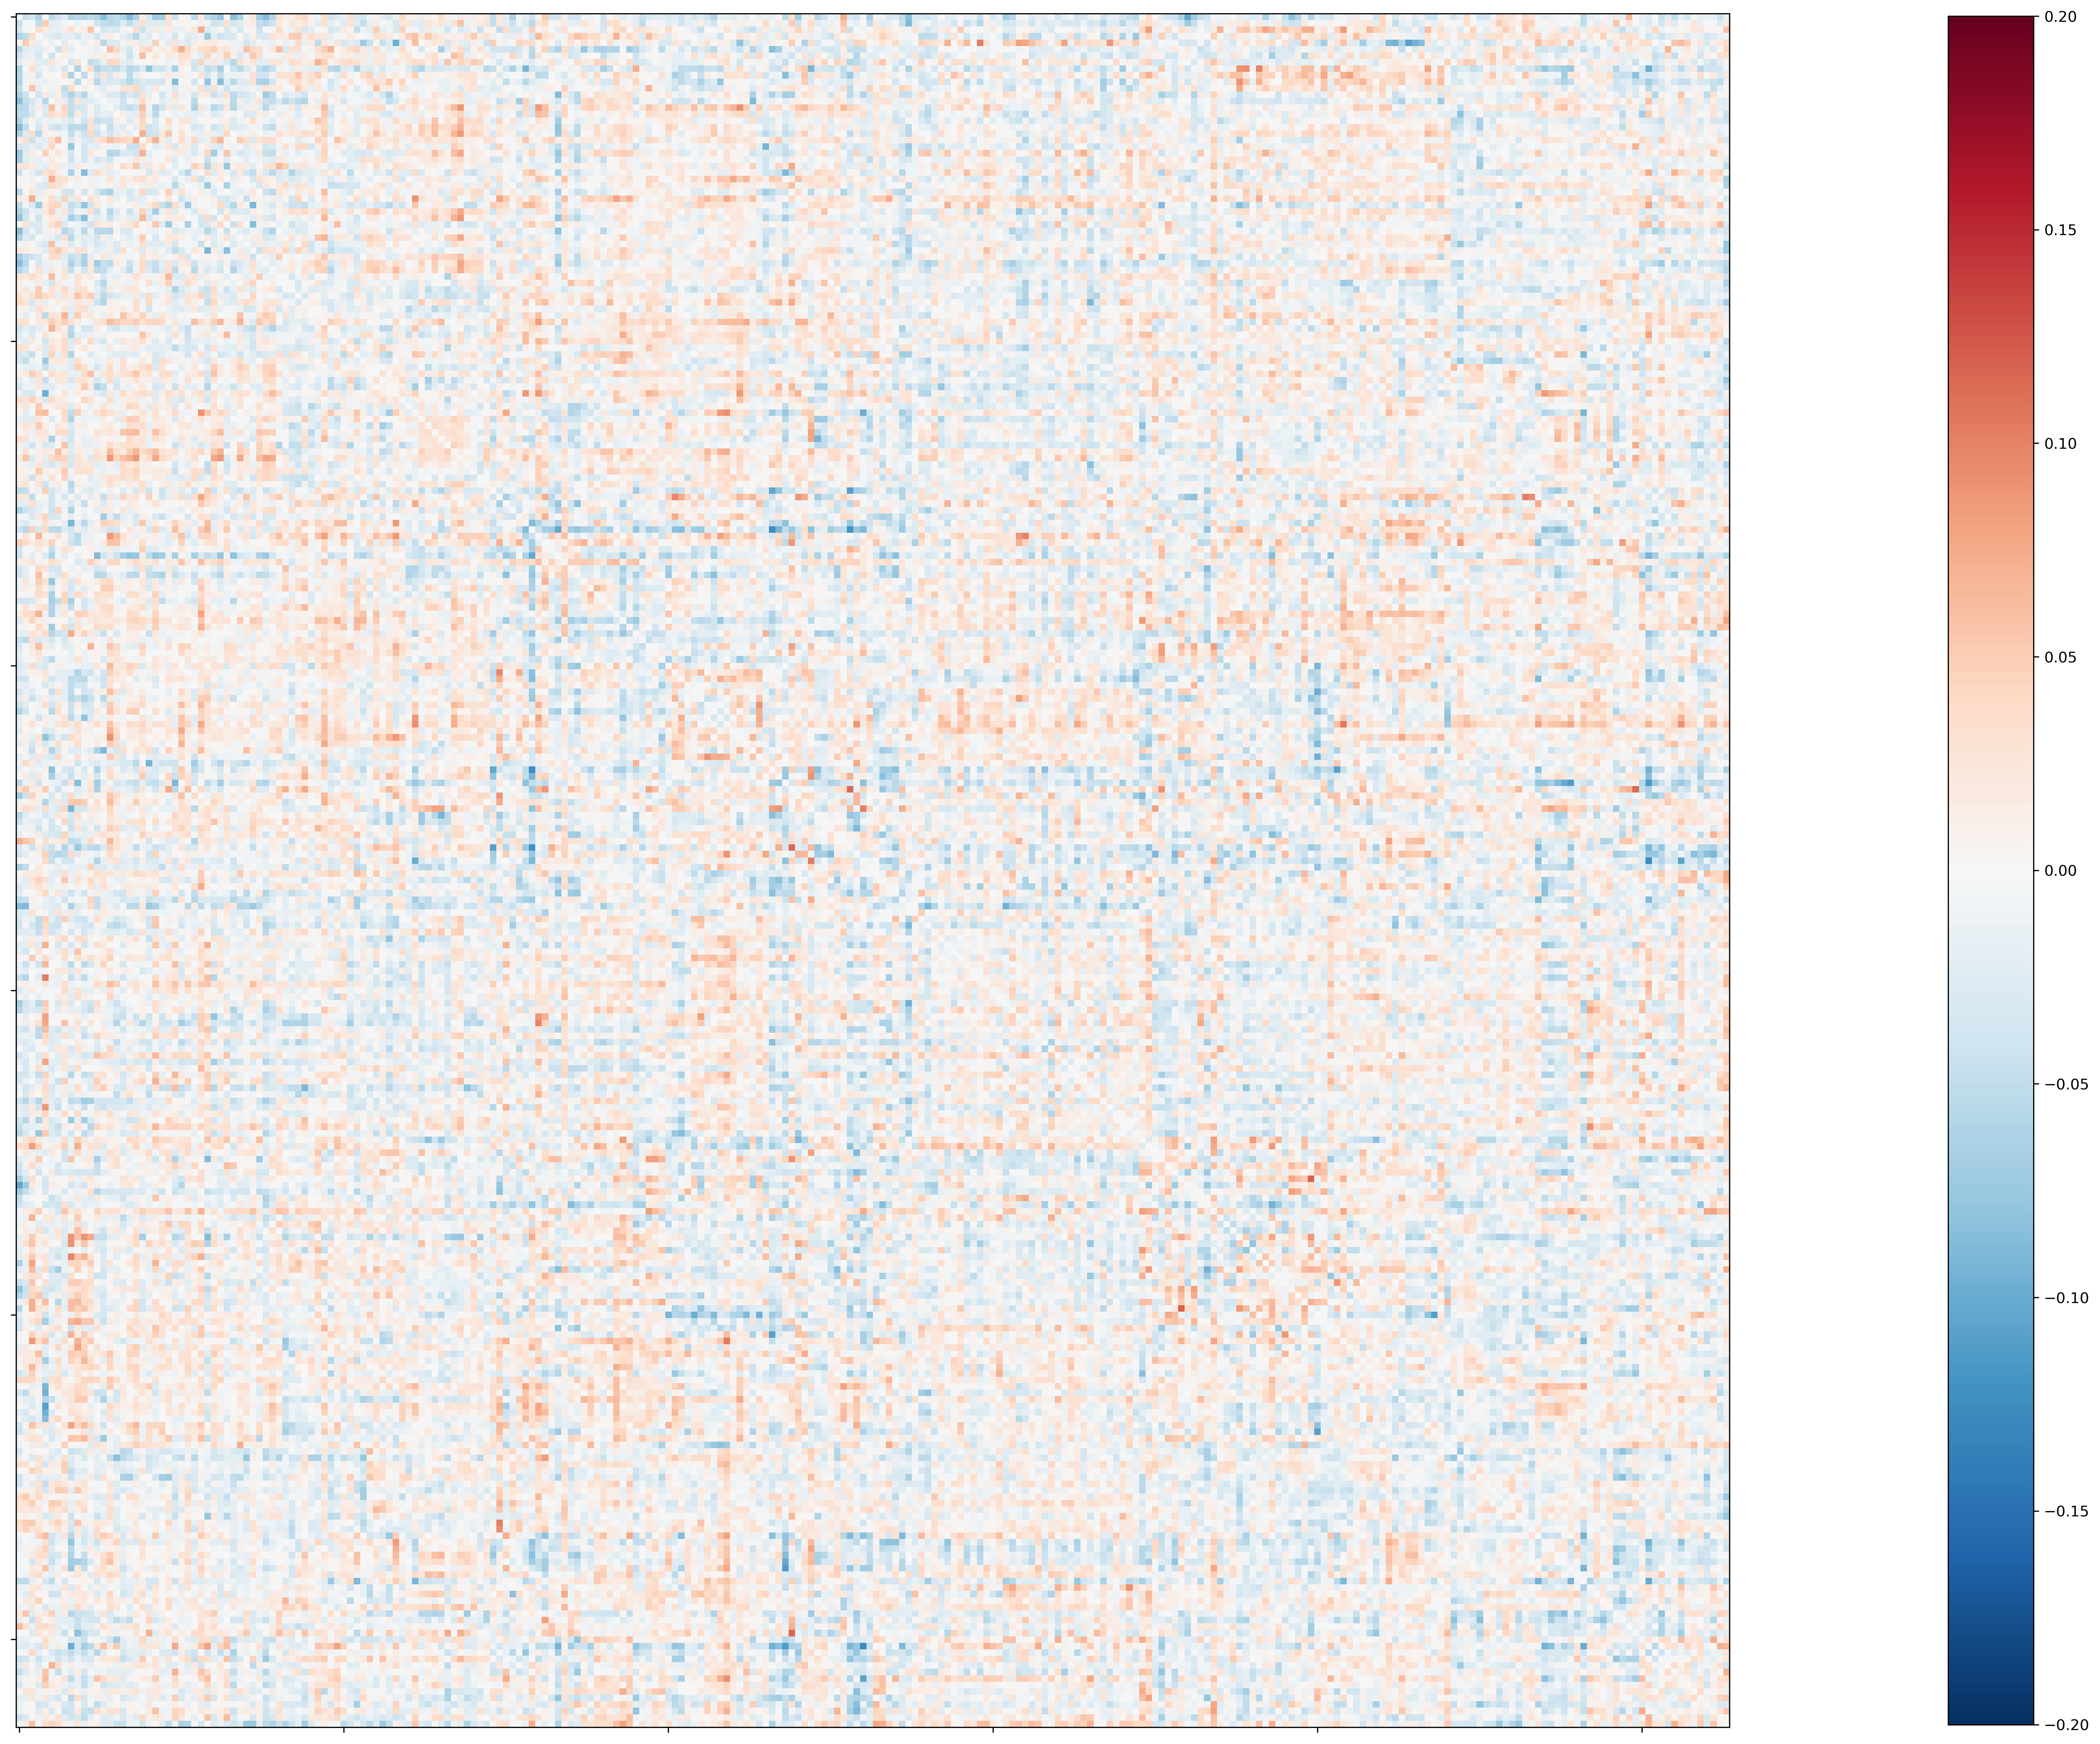

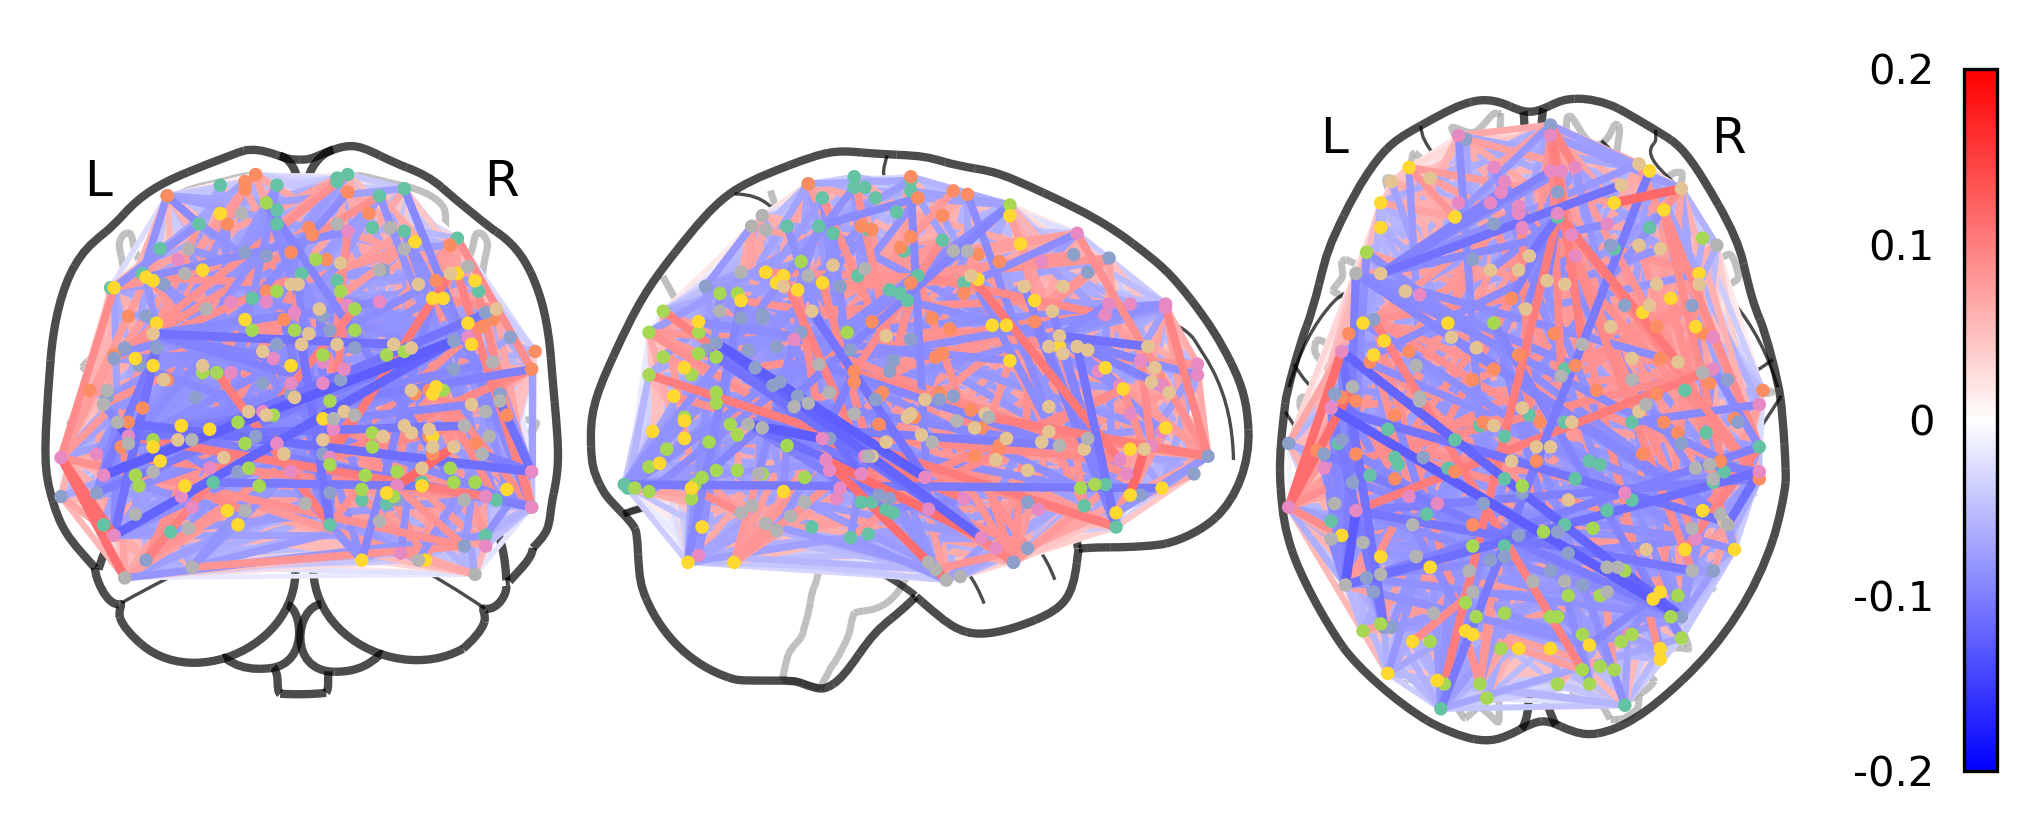

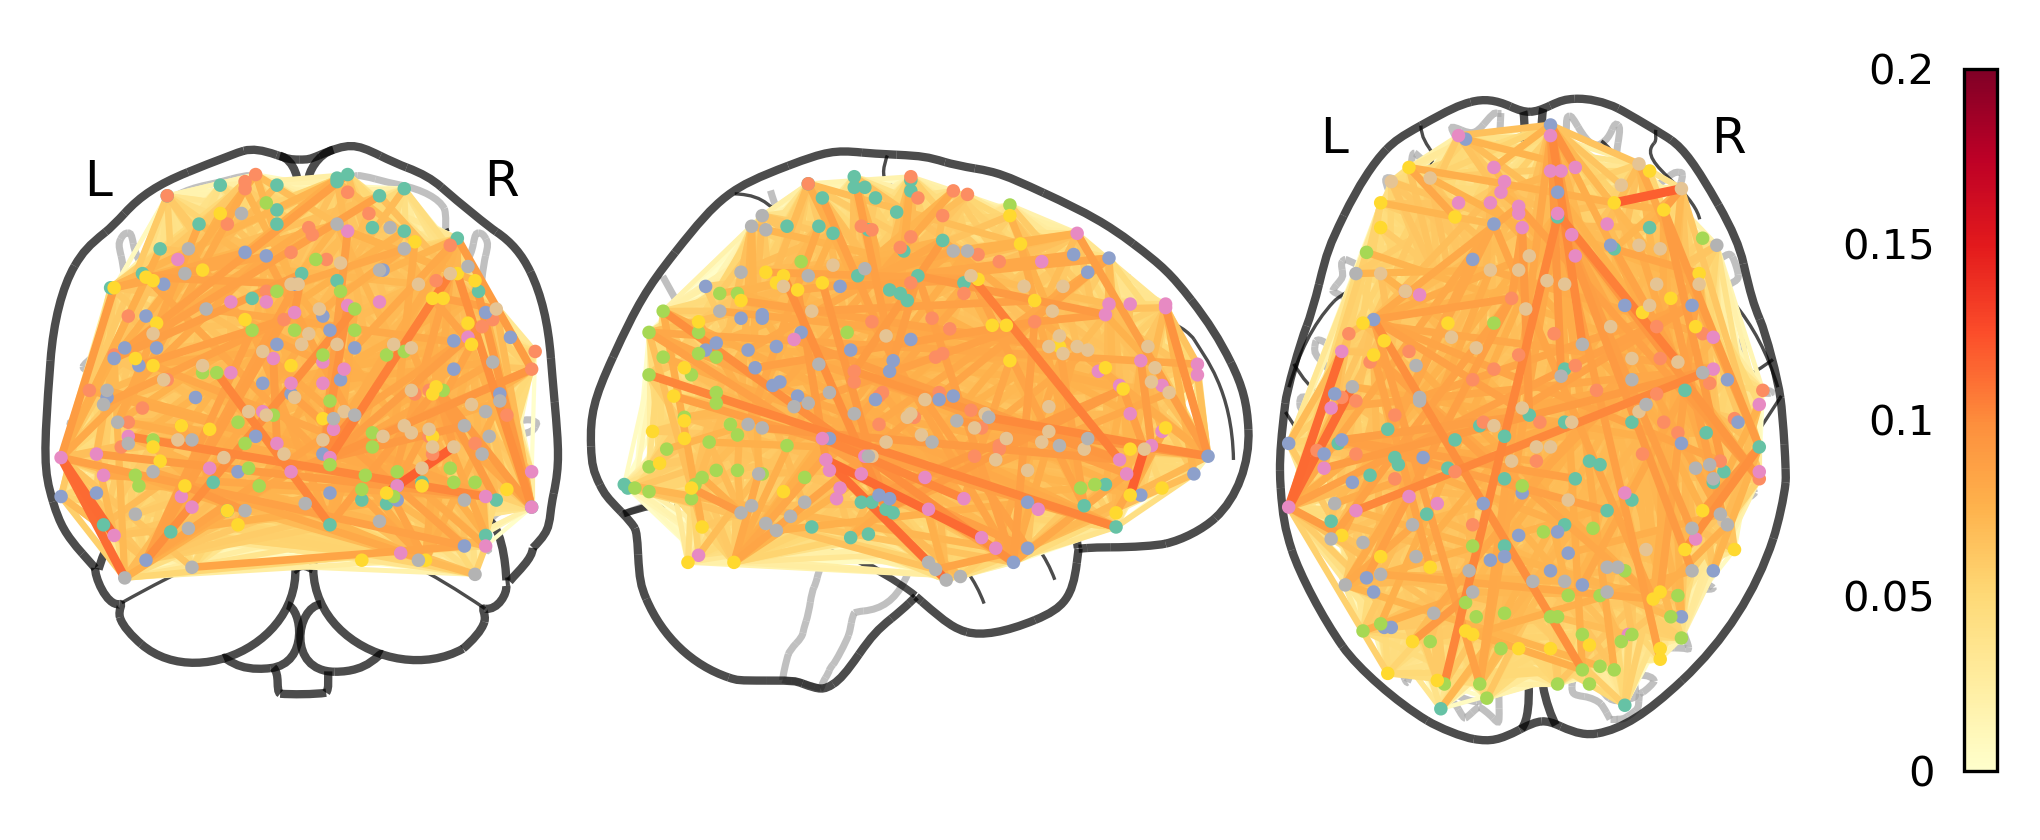

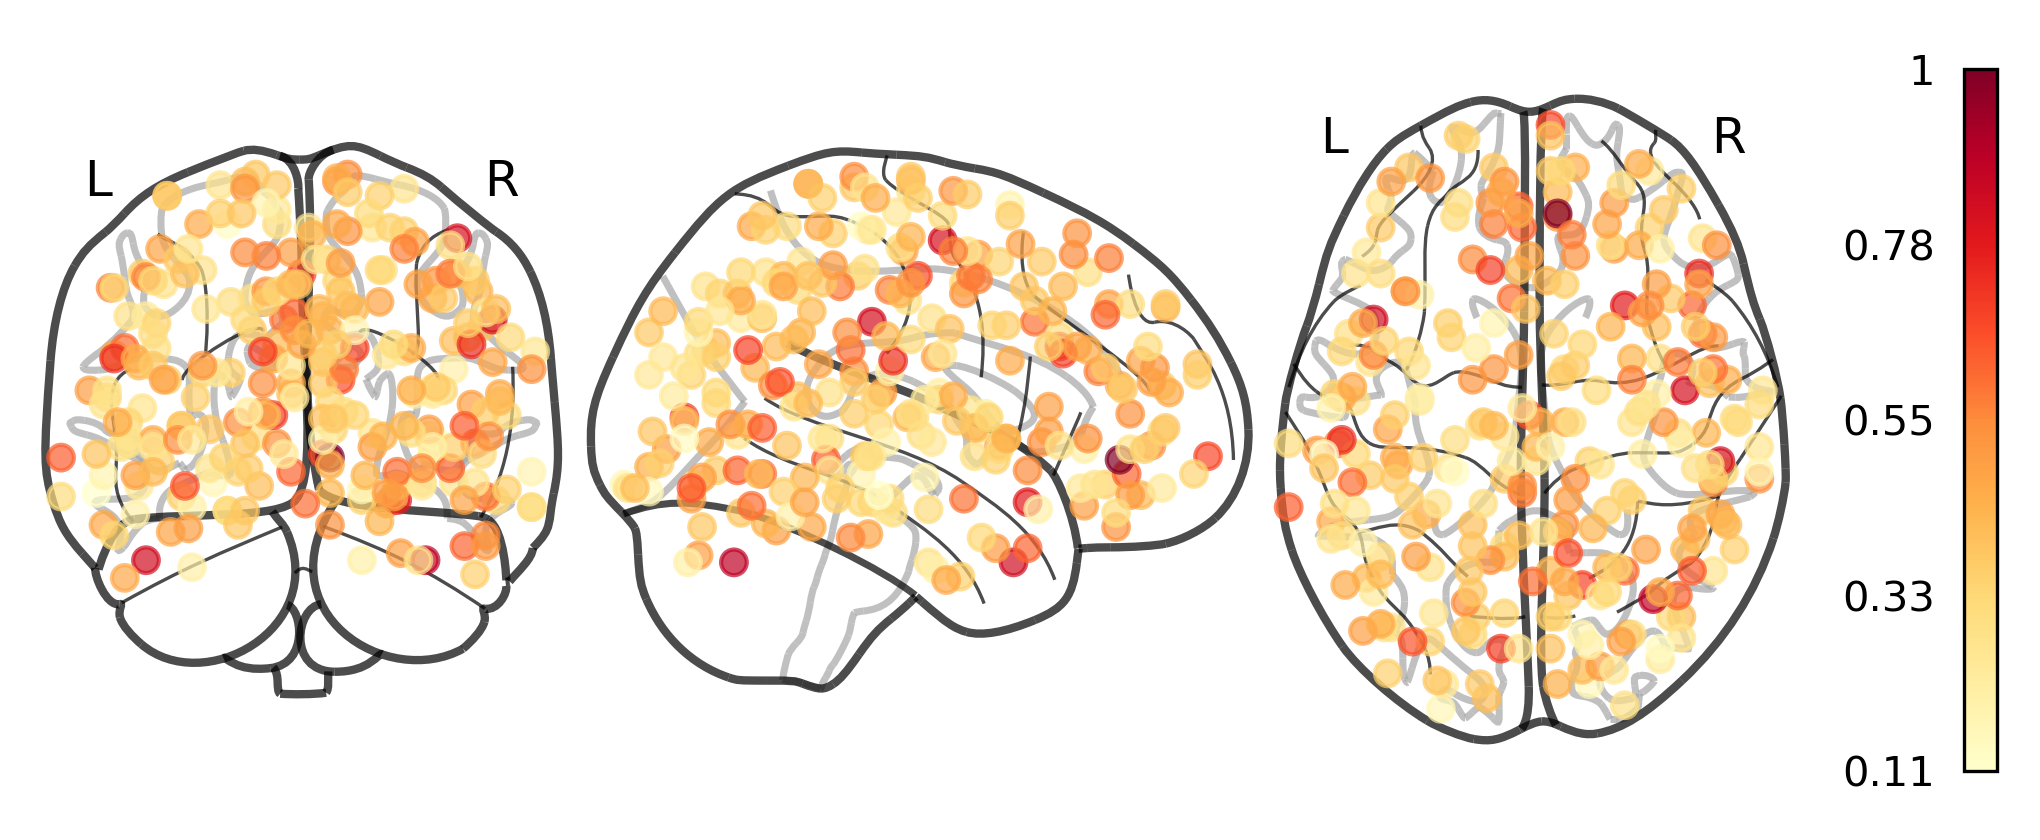

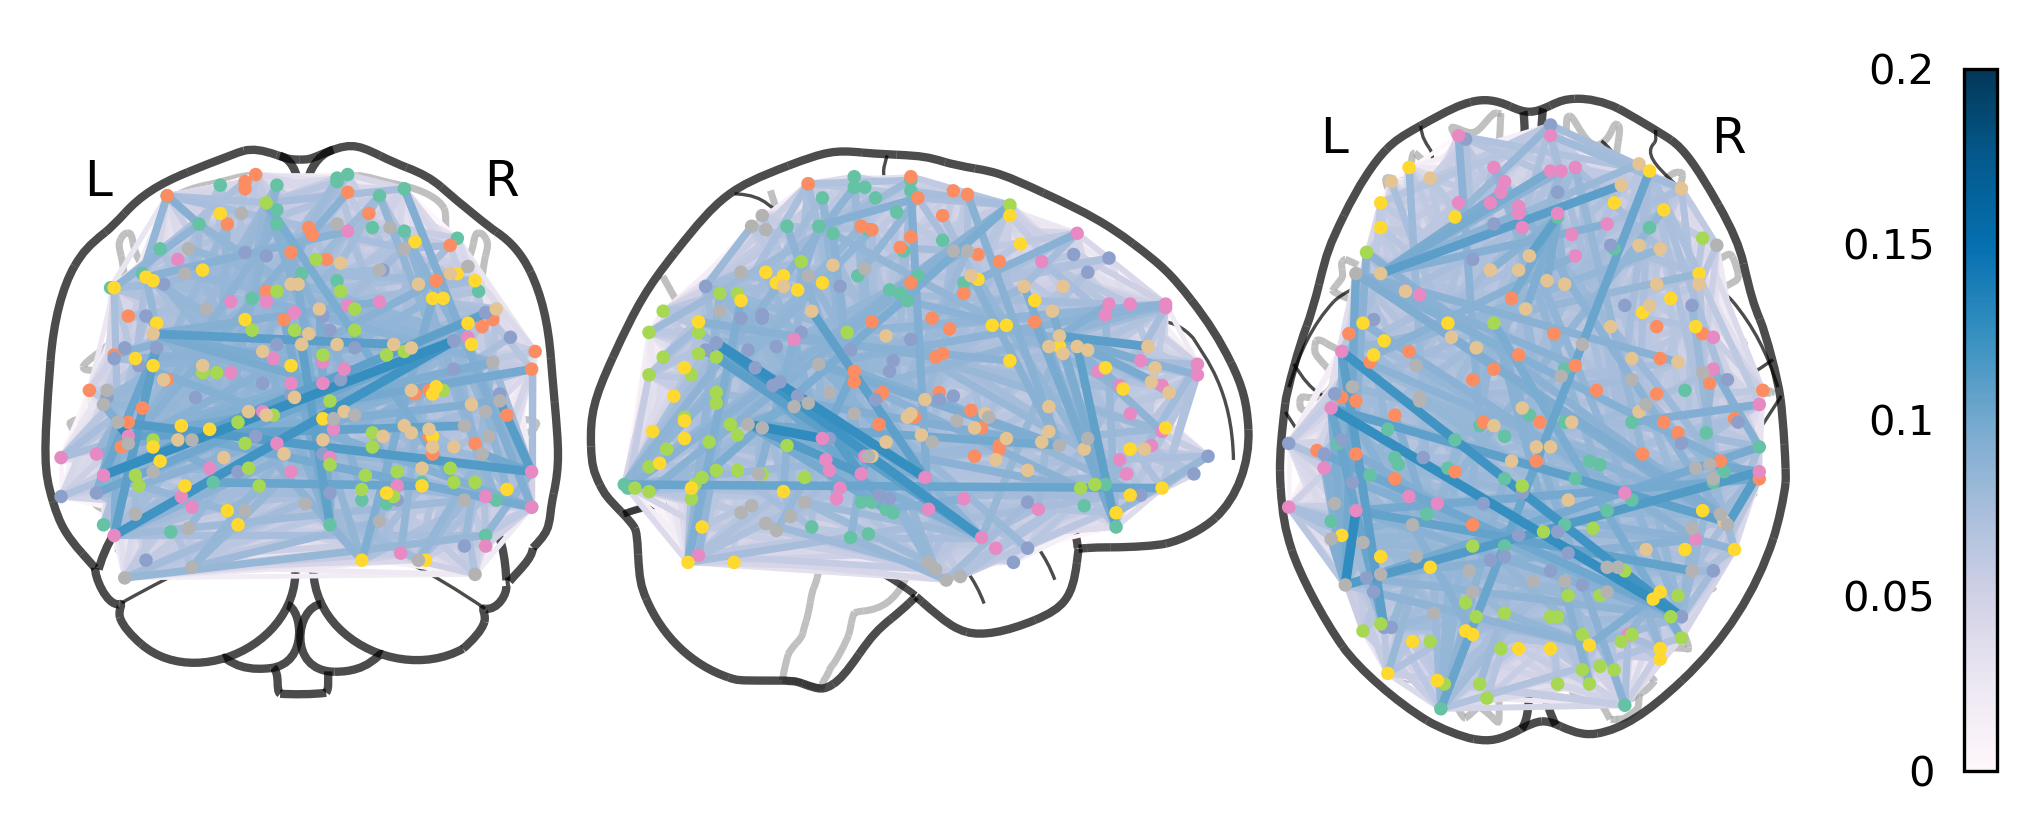

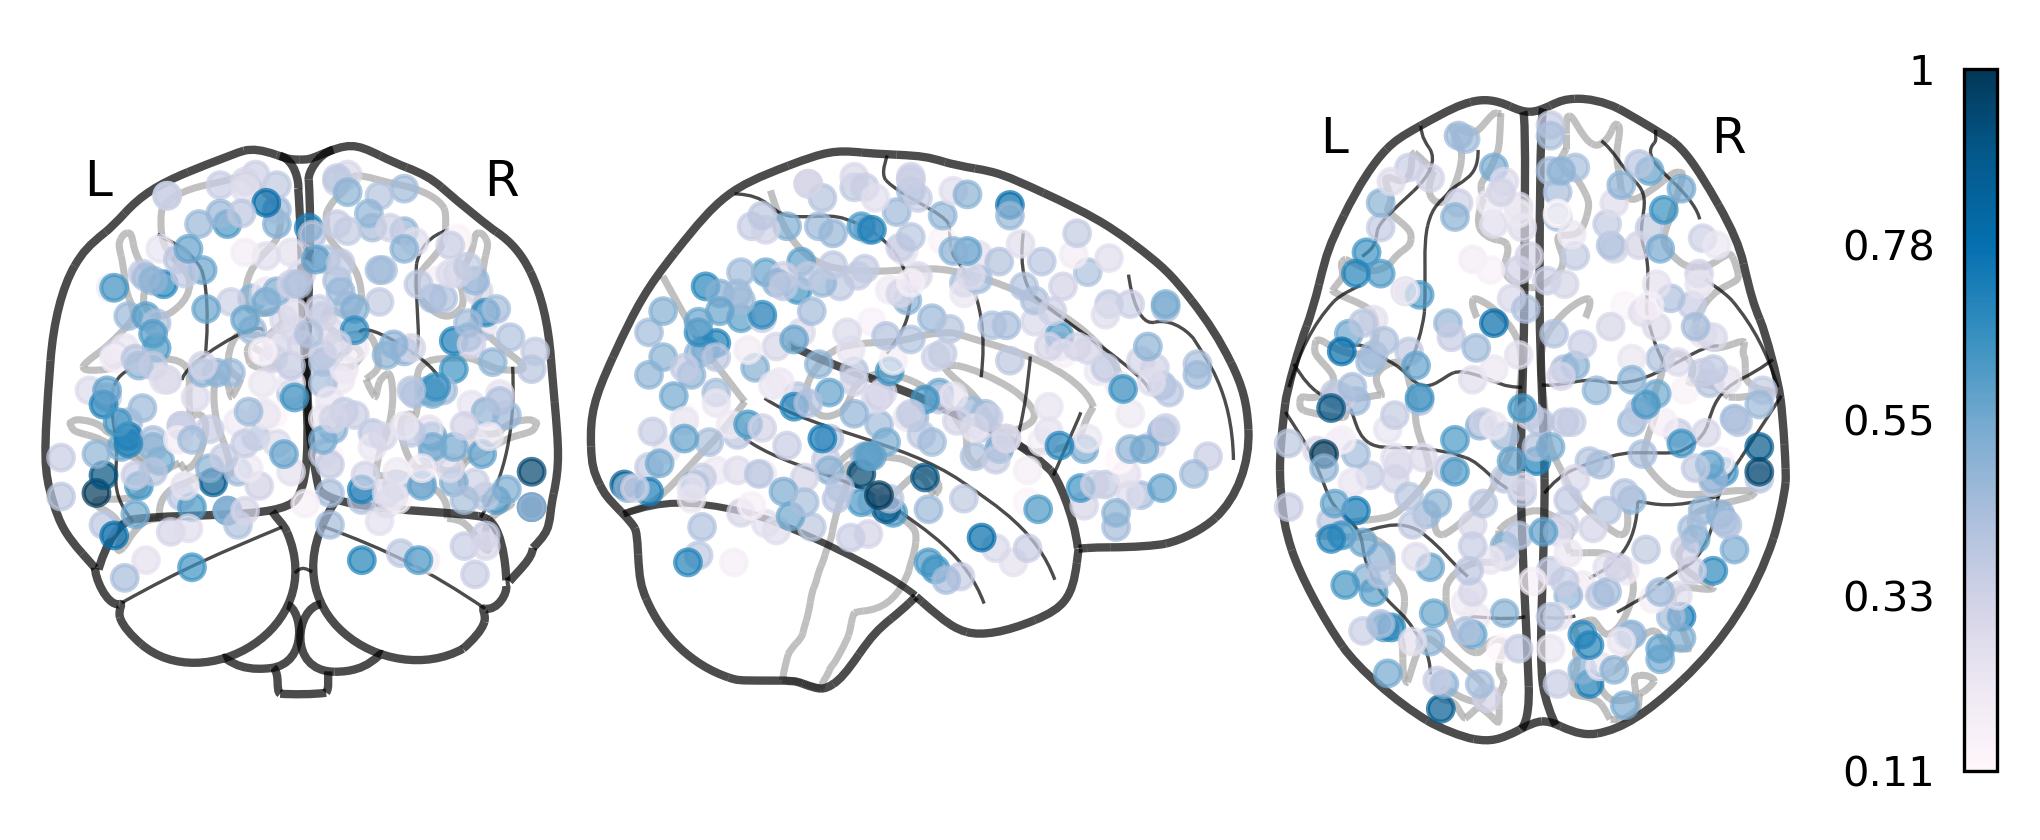

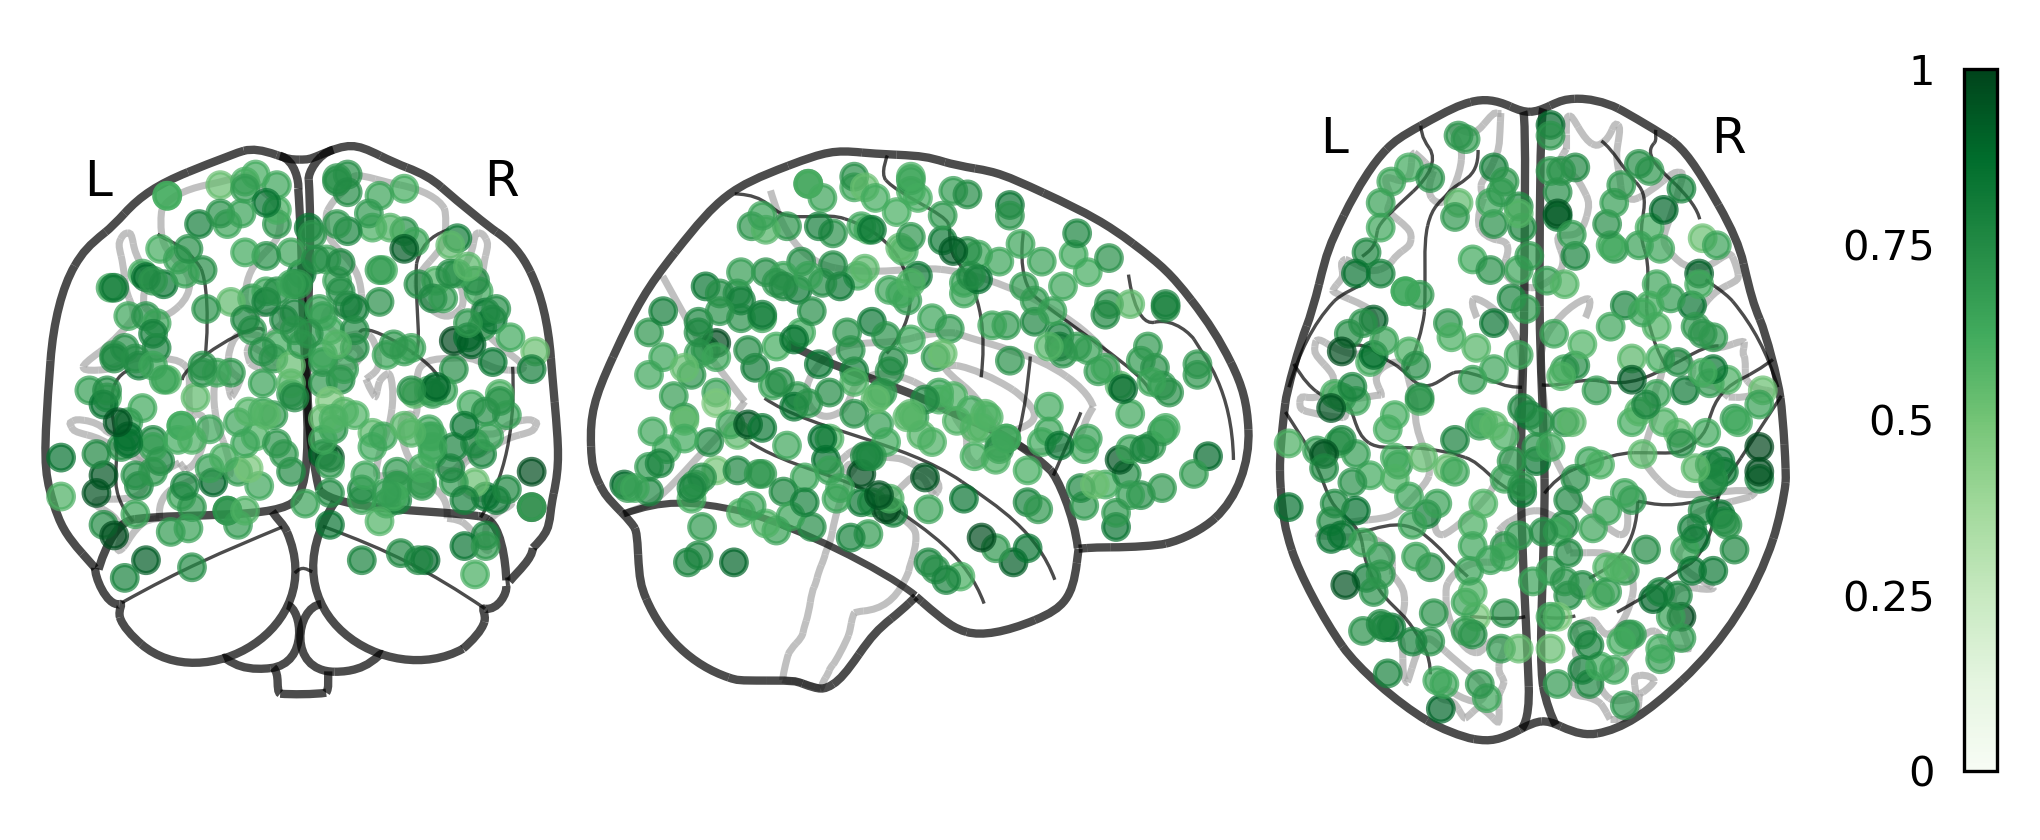

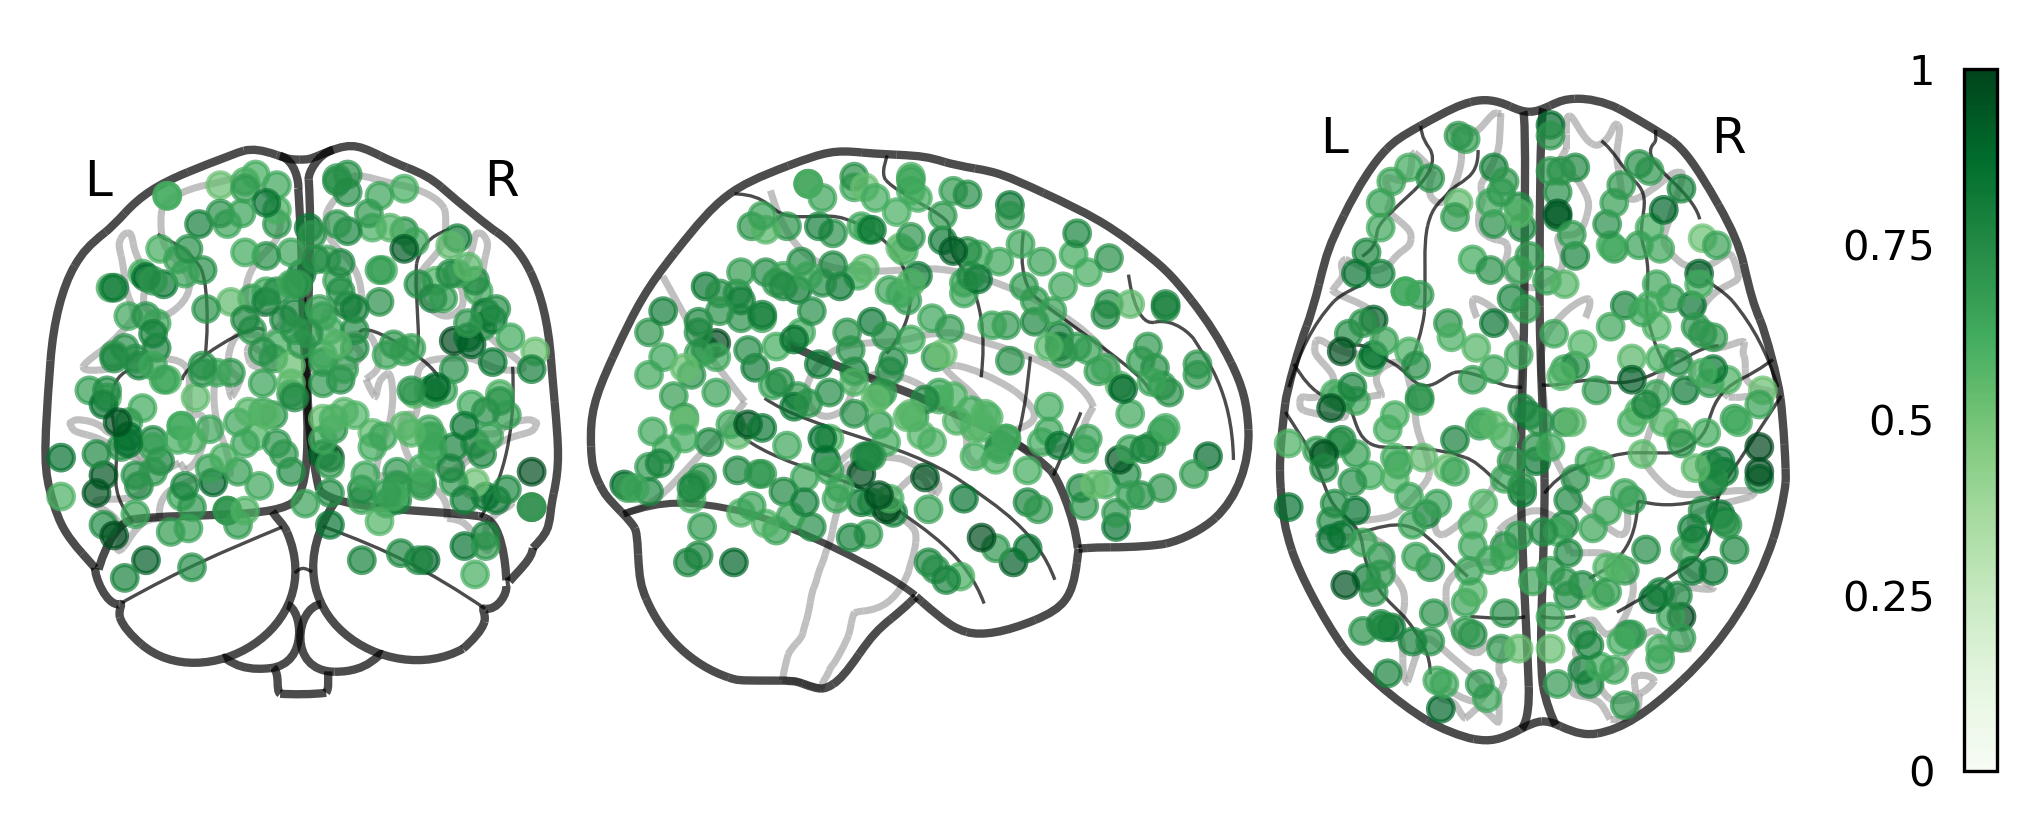

In [10]:
pls_coef = avg_coef
pls_coef_min = np.min(pls_coef)
pls_coef_max = np.max(pls_coef)
print(pls_coef.shape, pls_coef_min, pls_coef_max)

pls_coef_fc = create_power_fc_matrix(pls_coef)
vmin = -0.2
vmax = 0.2

plotting.plot_matrix(
    pls_coef_fc, colorbar=True, vmin=vmin, vmax=vmax, 
    figure=(20, 20))
plotting.plot_connectome(
    pls_coef_fc, coords, colorbar=True, edge_threshold=0, 
    node_size=5, edge_vmin=vmin, edge_vmax=vmax)

# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(pls_coef_fc, 0, pls_coef_max)
negative_edges = np.clip(pls_coef_fc, pls_coef_min, 0)

# calculate strength for positive edges
node_strength_positive = np.sum(np.abs(positive_edges), axis=0)
node_strength_positive /= np.max(node_strength_positive)

# calculate strength for negative edges
node_strength_negative = np.sum(np.abs(negative_edges), axis=0)
node_strength_negative /= np.max(node_strength_negative)

# plot nodes' strength for positive edges
plotting.plot_connectome(
    positive_edges, coords, colorbar=True, node_size=5,
    edge_vmin=0, edge_vmax=vmax, edge_cmap="YlOrRd")
plotting.plot_markers(
    node_strength_positive, coords, node_cmap="YlOrRd")

# plot nodes' strength for negative edges
plotting.plot_connectome(
    -negative_edges, coords, colorbar=True, node_size=5,
    edge_vmin=0, edge_vmax=vmax, edge_cmap="PuBu")
plotting.plot_markers(
    node_strength_negative, coords, node_cmap="PuBu")

node_strength = np.sum(np.abs(pls_coef_fc), axis=0)
node_strength /= np.max(node_strength)

plotting.plot_markers(
    node_strength, coords, node_threshold=0, node_vmin=0, 
    node_vmax=np.max(node_strength), node_cmap="Greens")
plotting.plot_markers(
    node_strength, coords, node_threshold=0.5, node_vmin=0, 
    node_vmax=np.max(node_strength), node_cmap="Greens")

In [ ]:
%%time
train_scores = []
test_scores = []

for k in range(100, 5000, 100):
    y_k = y
    X_k = X
    
    train_k = []
    test_k = []

    for i in range(0, 1000):
        X_train, X_test, y_train, y_test = train_test_split(
            X_k, y_k, test_size=0.3)
        
        ridge = Ridge(alpha=k).fit(X_train, y_train)

        train_k.append(ridge.score(X_train, y_train))
        test_k.append(ridge.score(X_test, y_test))

    train_scores.append(np.mean(train_k))
    test_scores.append(np.mean(test_k))

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Train r^2:", avg_train_score)
print("Test r^2:", avg_test_score)

In [ ]:
x_axis = range(100, 5000, 100)
plt.figure(1, figsize=(10, 10))
plt.title(selected_measure)
plt.plot(x_axis, train_scores, label="Train")
plt.plot(x_axis), test_scores, label="Test")
plt.legend()

def annot_max(x, y):
    xmax = x[np.argmax(y)]
    ymax = np.amax(y)
    text = "x={:.3f}, y={:.3f}".format(xmax, ymax)
    ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(range(0, len(test_scores)), test_scores)

plt.show()